## Import Libraries

In [ ]:
import pandas as pd
import re
import random
import unicodedata
from random_names import random_names
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import spacy
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from transformers import pipeline
import numpy as np
import gensim
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from gensim.models import Word2Vec
from scipy.stats import pearsonr
import ast
import os

## **Emotion mapping**

In [ ]:
# Emotion mapping from Teacher’s guide
emotion_mapping = {
    "happiness": [
        "joy", "optimism", "approval", "pride", "gratitude", "confidence",
        "satisfaction", "hope", "love", "excitement", "caring", "relief", "admiration",
        "amusement", "anticipation", "encouragement", "desire", "happiness"
    ],
    "sadness": [
        "disappointment", "nostalgia", "remorse", "pain", "stress", "regret",
        "resignation", "despair", "confusion", "uncertainty", "sadness"
    ],
    "anger": [
        "anger", "annoyance", "disapproval", "frustration", "disbelief", "warning",
        "rejection"
    ],
    "disgust": [
        "disgust"
    ],
    "fear": [
        "fear", "nervousness", "worry", "anxiety", "doubt", "insecurity", "urgency",
        "panic"
    ],
    "surprise": [
        "surprise", "realization", "shock", "amazement", "wonder"
    ],
    "neutral": [
        "neutral", "mixed", "trust", "agreement", "instruction", "suggestion",
        "request", "confirmation", "acceptance", "reassurance", "clarification",
        "understanding", "certainty"
    ]
}

In [ ]:
# Reverse mapping for quick lookup
emotion_reverse_mapping = {
    sub_emotion: core_emotion
    for core_emotion, sub_emotions in emotion_mapping.items()
    for sub_emotion in sub_emotions
}

## Preprocessing 

### Replace "[NAME]" in GoEmotions with a random name from random_names.py to try and keep context of the sentences and clean the dataset from artifacts and non-ASCII characters

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Remove all types of apostrophe encoding issues
    text = re.sub(r"â€™|’", "'", text)  # Convert corrupted apostrophes to standard '

    # Remove unwanted Unicode symbols while keeping apostrophes
    text = re.sub(r"[^\x00-\x7F']", "", text)  # Remove all non-ASCII characters except apostrophes

    # Replace [NAME] placeholders with two random names
    name_choices = random.sample(random_names, 2)
    text = re.sub(r"\[NAME\]", name_choices[0], text, count=1)
    text = re.sub(r"\[NAME\]", name_choices[1], text)

    # Remove unwanted symbols and formatting issues
    text = re.sub(r"\$(\w+)\$", r"\1", text)  # Remove $ around words
    text = re.sub(r"(\d+)\$", r"$\1", text)  # Normalize "40$" to "$40"
    text = re.sub(r"#(\w+)", r"\1", text)  # Remove hashtags but keep words
    text = re.sub(r"@\w+", "", text)  # Remove @username mentions
    text = re.sub(r"^>\s*", "", text)  # Remove only ">" at the start but keep the sentence


    # Triple and double quotes but keep actual quotes inside sentences
    text = re.sub(r'^"{2,}', '', text)  # Remove leading double or triple quotes
    text = re.sub(r'"{2,}$', '', text)  # Remove trailing double or triple quotes
    text = re.sub(r"'{2,}", "'", text)  # Convert two or more apostrophes into a single one

    return text.strip()

### Mapped emotions

In [ ]:
# Function to map multi-label emotions to a single core emotion
def map_emotions(row, emotion_columns):
    detected_emotions = [col for col in emotion_columns if row[col] == 1]
    core_emotions = set(emotion_reverse_mapping.get(emotion, "neutral") for emotion in detected_emotions)
    return list(core_emotions)[0] if core_emotions else "neutral"

In [ ]:
# Function to clean a GoEmotions dataset
def process_goemotions(file_path):
    print(f"Processing file: {file_path}")

    # Load dataset
    df = pd.read_csv(file_path)

    # Drop unnecessary metadata columns
    metadata_columns = ["id", "author", "subreddit", "link_id", "parent_id", "created_utc", "rater_id"]
    df.drop(columns=metadata_columns, inplace=True, errors="ignore")

    # Remove rows where example_very_unclear = True
    if "example_very_unclear" in df.columns:
        df = df[df["example_very_unclear"] != True]  # Keep only clear examples
        df.drop(columns=["example_very_unclear"], inplace=True, errors="ignore")

    # Identify emotion columns
    emotion_columns = [col for col in df.columns if col not in ["text"]]

    # Apply emotion mapping
    df["emotion"] = df.apply(lambda row: map_emotions(row, emotion_columns), axis=1)

    # Keep only relevant columns
    df = df[["text", "emotion"]].rename(columns={"text": "sentence"})

    # Apply text cleaning
    df["sentence"] = df["sentence"].apply(clean_text)

    # Add dataset source column
    df["dataset_source"] = "GoEmotions"

    # Save cleaned dataset
    cleaned_file_path = file_path.replace(".csv", "_cleaned.csv")
    df.to_csv(cleaned_file_path, index=False)
    print(f"Saved cleaned file: {cleaned_file_path}")

In [ ]:
process_goemotions("GoEmotion\goemotions_1.csv")

Processing file: GoEmotion\goemotions_1.csv
Saved cleaned file: GoEmotion\goemotions_1_cleaned.csv


In [ ]:
process_goemotions("GoEmotion\goemotions_2.csv")

Processing file: GoEmotion\goemotions_2.csv
Saved cleaned file: GoEmotion\goemotions_2_cleaned.csv


In [ ]:
process_goemotions("GoEmotion\goemotions_3.csv")

Processing file: GoEmotion\goemotions_3.csv
Saved cleaned file: GoEmotion\goemotions_3_cleaned.csv


In [ ]:
# Load the three cleaned GoEmotions datasets
df1 = pd.read_csv("GoEmotion\goemotions_1_cleaned.csv")
df2 = pd.read_csv("GoEmotion\goemotions_2_cleaned.csv")
df3 = pd.read_csv("GoEmotion\goemotions_3_cleaned.csv")

# Merge them together
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# Save the merged dataset
merged_df.to_csv("goemotions_cleaned_merged.csv", index=False)

print("Successfully merged and saved as goemotions_cleaned_merged.csv")

Successfully merged and saved as goemotions_cleaned_merged.csv


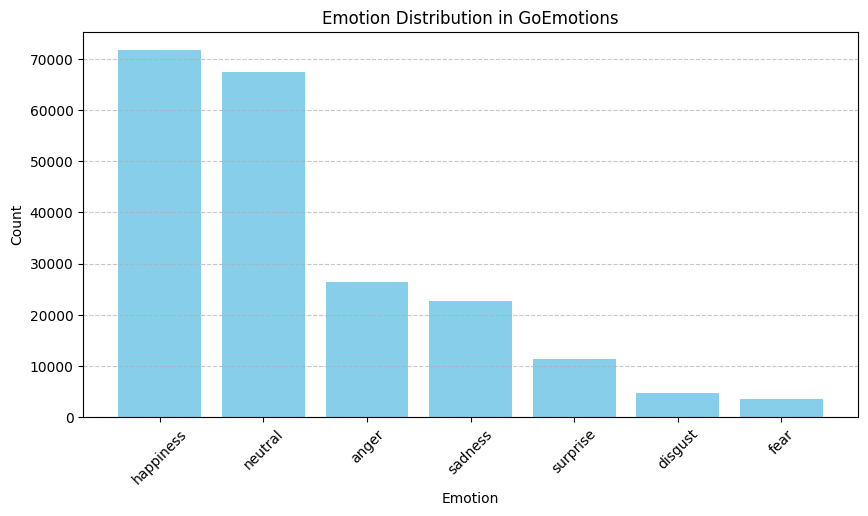

In [ ]:
# Load the merged GoEmotions dataset
file_path = "goemotions_cleaned_merged.csv"  # Adjust the path if needed
df = pd.read_csv(file_path)

# Count occurrences of each emotion
emotion_counts = df["emotion"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.index, emotion_counts.values, color="skyblue")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Distribution in GoEmotions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

### Add MELD DataSet

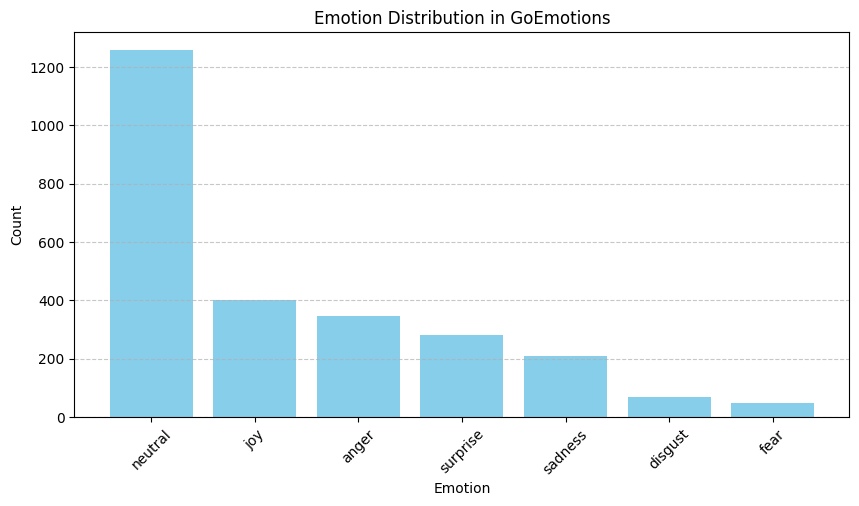

In [ ]:
# Load the merged GoEmotions datas
df = pd.read_csv(r"MELD.Raw\MELD.Raw\test_sent_emo.csv")

# Count occurrences of each emotion
emotion_counts = df["Emotion"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.index, emotion_counts.values, color="skyblue")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Distribution in GoEmotions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# Clean the text in the MELD dataset from non-ASCII characters and unwanted symbols
def clean_text_meld(text):
    if not isinstance(text, str):
        return ""

    # Remove all types of apostrophe encoding issues
    text = re.sub(r"Â|’", "'", text)  # Convert corrupted apostrophes to standard '

    # Remove unwanted Unicode symbols while keeping apostrophes
    text = re.sub(r"[^\x00-\x7F']", "", text)  # Remove all non-ASCII characters except apostrophes

    # Remove unwanted symbols and formatting issues
    text = re.sub(r"\$(\w+)\$", r"\1", text)  # Remove $ around words
    text = re.sub(r"(\d+)\$", r"$\1", text)  # Normalize "40$" to "$40"
    text = re.sub(r"#(\w+)", r"\1", text)  # Remove hashtags but keep words
    text = re.sub(r"@\w+", "", text)  # Remove @username mentions
    text = re.sub(r"^>\s*", "", text)  # Remove only ">" at the start but keep the sentence

    # Remove triple and double quotes but keep actual quotes inside sentences**
    text = re.sub(r'^"{2,}', '', text)  # Remove leading double or triple quotes
    text = re.sub(r'"{2,}$', '', text)  # Remove trailing double or triple quotes
    text = re.sub(r"'{2,}", "'", text)  # Convert two or more apostrophes into a single one

    return text.strip()

In [ ]:
# Normalize the MELD dataset
def clean_meld(file_path):
    """Cleans the MELD dataset by fixing encoding issues and standardizing structure."""
    print(f"Processing file: {file_path}")

    # Load dataset
    df = pd.read_csv(file_path)

    # Keep only relevant columns and rename them
    df = df[["Utterance", "Emotion"]].rename(columns={"Utterance": "sentence", "Emotion": "emotion"})

    # Add dataset source column
    df["dataset_source"] = "MELD"

    # Apply text cleaning function
    df["sentence"] = df["sentence"].apply(clean_text_meld)


    # Standardize emotion labels
    emotion_mapping = {"joy": "happiness"}
    df["emotion"] = df["emotion"].replace(emotion_mapping)

    # Save cleaned dataset with "_cleaned" suffix
    output_path = file_path.replace(".csv", "_cleaned.csv")
    df.to_csv(output_path, index=False)

    print(f"Successfully cleaned and saved: {output_path}")

In [ ]:
clean_meld(r"MELD.Raw\MELD.Raw\test_sent_emo.csv")

Processing file: MELD.Raw\MELD.Raw	est_sent_emo.csv
Successfully cleaned and saved: MELD.Raw\MELD.Raw	est_sent_emo_cleaned.csv


In [ ]:
clean_meld(r"MELD.Raw\MELD.Raw\dev_sent_emo.csv")

Processing file: MELD.Raw\MELD.Raw\dev_sent_emo.csv
Successfully cleaned and saved: MELD.Raw\MELD.Raw\dev_sent_emo_cleaned.csv


In [ ]:
# Load the three cleaned GoEmotions datasets
df_meld1 = pd.read_csv(r"MELD.Raw\MELD.Raw\test_sent_emo_cleaned.csv")
df_meld2 = pd.read_csv(r"MELD.Raw\MELD.Raw\dev_sent_emo_cleaned.csv")

# Merge them together
merged_df_meld = pd.concat([df_meld1, df_meld2], ignore_index=True)

# Save the merged dataset
merged_df_meld.to_csv("meld_cleaned_merged.csv", index=False)

print("Successfully merged and saved as goemotions_cleaned_merged.csv")

Successfully merged and saved as goemotions_cleaned_merged.csv


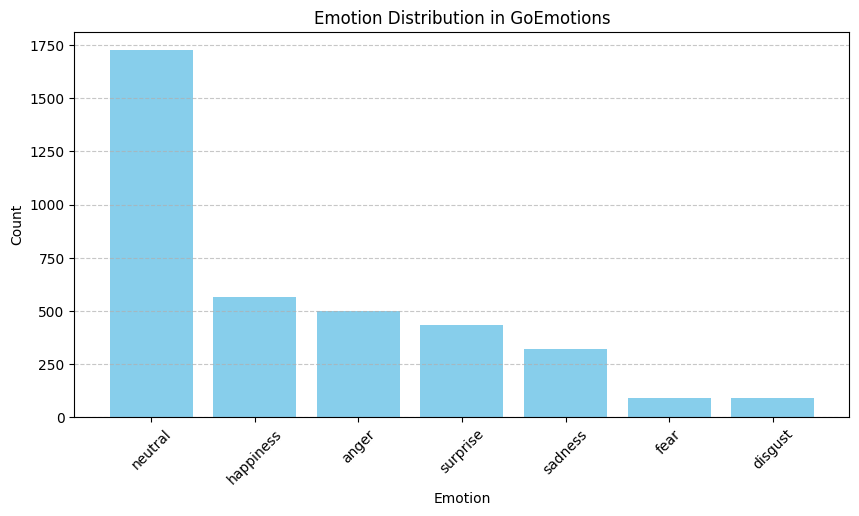

In [ ]:
# Load the merged GoEmotions dataset
file_path = "meld_cleaned_merged.csv"
df = pd.read_csv(file_path)

# Count occurrences of each emotion
emotion_counts = df["emotion"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.index, emotion_counts.values, color="skyblue")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Distribution in GoEmotions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

### Merging MELD and goemotions datasets 

In [ ]:
# Load the three cleaned GoEmotions datasets
df_meld1 = pd.read_csv("goemotions_cleaned_merged.csv")
df_meld2 = pd.read_csv("meld_cleaned_merged.csv")

# Merge them together
merged_df_meld = pd.concat([df_meld1, df_meld2], ignore_index=True)

# Save the merged dataset
merged_df_meld.to_csv("merged_dataset.csv", index=False)

print("Successfully merged and saved as merged_dataset.csv")

Successfully merged and saved as merged_dataset.csv


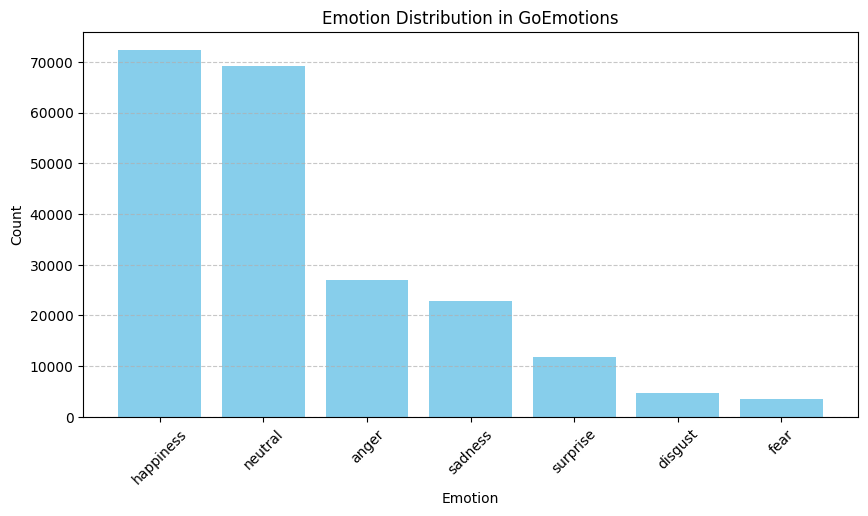

In [ ]:
# Load the merged GoEmotions dataset
file_path = "merged_dataset.csv"
df = pd.read_csv(file_path)

# Count occurrences of each emotion
emotion_counts = df["emotion"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.index, emotion_counts.values, color="skyblue")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Distribution in GoEmotions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

---------------------------------

### POS TAGGING

In [ ]:
# Load the spacy model to GPU if possible
def load_spacy_model(use_gpu=True):
    """Loads Spacy's en_core_web_lg model with optional GPU support."""
    if use_gpu and torch.cuda.is_available():
        spacy.require_gpu()
        print("Running SpaCy with GPU acceleration!")
    else:
        print("Running SpaCy on CPU!")

    return spacy.load("en_core_web_lg")

# Extract POS tags from the dataset using Spacy
def extract_pos_tags(file_path, output_path, use_gpu=True):
    """Extracts POS tags from a dataset and saves the output."""
    print(f"Processing file: {file_path}")
    nlp = load_spacy_model(use_gpu)

    # Load dataset
    df = pd.read_csv(file_path)

    # Ensure 'sentence' column exists
    if "sentence" not in df.columns:
        raise ValueError("The dataset must have a 'sentence' column!")

    # 🔹 **Fix missing values (NaN)**
    df["sentence"] = df["sentence"].astype(str).fillna("")

    # Extract POS tags
    pos_tags = []
    for doc in tqdm(nlp.pipe(df["sentence"], batch_size=100, disable=["ner", "parser"]), total=len(df)):
        pos_tags.append([token.pos_ for token in doc])

    df["POS_Tags"] = pos_tags

    # Save processed dataset
    df.to_csv(output_path, index=False)
    print(f"POS tagging complete! Processed file saved as: {output_path}")

In [ ]:
# Example Usage:
extract_pos_tags("merged_dataset.csv", "merged_dataset_with_POS.csv", use_gpu=True)

Running SpaCy with GPU acceleration!
100%|██████████| 211533/211533 [02:07<00:00, 1657.67it/s]
POS tagging complete! Processed file saved as: merged_dataset_with_POS.csv


---------------------------------

### TF-IDF

In [ ]:
# Load the dataset and extract TF-IDF features
def extract_tfidf(file_path, output_file, max_features=50000, ngram_range=(1,3)):
    """Extracts TF-IDF features and saves them into a new column."""
    print(f"Processing file: {file_path}")

    # Load dataset
    df = pd.read_csv(file_path)

    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
    )

    # Fit & transform the text data
    print("Computing TF-IDF...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(df["sentence"].fillna("")))

    # Convert TF-IDF matrix into a list of feature dictionaries
    feature_names = vectorizer.get_feature_names_out()
    df["TF_IDF"] = [
        {feature_names[i]: tfidf_value for i, tfidf_value in zip(row.indices, row.data)}
        for row in tfidf_matrix
    ]

    # Save the updated dataset
    df.to_csv(output_file, index=False)
    print(f"Successfully saved TF-IDF extracted file: {output_file}")

    # Save the TF-IDF vectorizer for later use
    with open("tfidf_vectorizer_50k.pkl", "wb") as f:
        pickle.dump(vectorizer, f)
    print("Saved TF-IDF vectorizer for later use.")


In [ ]:
# Example usage:
extract_tfidf("merged_dataset.csv", "merged_dataset_TF-IDF_20k.csv", max_features=20000)

rocessing file: merged_dataset.csv
Computing TF-IDF...
100%|██████████| 211533/211533 [00:03<00:00, 62818.57it/s]
Successfully saved TF-IDF extracted file: merged_dataset_TF-IDF_20k.csv
Saved TF-IDF vectorizer for later use.


In [ ]:
extract_tfidf("merged_dataset.csv", "merged_dataset_TF-IDF_50k.csv", max_features=50000)

Processing file: merged_dataset.csv
Computing TF-IDF...


100%|██████████| 211533/211533 [00:08<00:00, 25412.82it/s]


Successfully saved TF-IDF extracted file: merged_dataset_TF-IDF_50k.csv
Saved TF-IDF vectorizer for later use.


-------------------------------------

### Sentiment Score

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...


True

In [ ]:
# Extract VADER sentiment scores from the dataset
def extract_vader_sentiment(file_path, output_file):
    """Extracts VADER sentiment scores and saves them into a new column."""
    print(f"Processing file: {file_path}")

    # Load dataset
    df = pd.read_csv(file_path)

    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Apply sentiment analysis
    tqdm.pandas(desc="Computing Sentiment Scores")
    df["Sentiment_Score"] = df["sentence"].fillna("").progress_apply(lambda x: sia.polarity_scores(x)["compound"])

    # Save the updated dataset
    df.to_csv(output_file, index=False)
    print(f"Successfully saved sentiment-extracted file: {output_file}")

    # Summary statistics
    print("\nSentiment Score Distribution:")
    print(df["Sentiment_Score"].describe())

In [ ]:
extract_vader_sentiment("CARER_processed_v2_afterNER.csv", "CARER_processed_v2_afterNER.csv")

Processing file: CARER_processed_v2_afterNER.csv


Computing Sentiment Scores: 100%|██████████| 381626/381626 [00:42<00:00, 9020.20it/s]


Successfully saved sentiment-extracted file: CARER_processed_v2_afterNER.csv

Sentiment Score Distribution:
count    381626.000000
mean          0.050799
std           0.552475
min          -0.995200
25%          -0.440400
50%           0.025800
75%           0.570900
max           0.994700
Name: Sentiment_Score, dtype: float64


### Using DistilBERT-based sentiment model

In [ ]:
# Load the dataset and extract DistilBERT sentiment scores
def extract_distilbert_sentiment(file_path, output_file):
    """Extracts sentiment scores using DistilBERT and saves them in a new column."""
    print(f"Processing file: {file_path}")

    # Load dataset
    df = pd.read_csv(file_path)

    # Initialize DistilBERT Sentiment Analysis Pipeline
    sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0)

    # Compute sentiment scores
    tqdm.pandas()
    def get_sentiment_score(text):
        """Runs DistilBERT sentiment analysis and returns a probability score."""
        if not isinstance(text, str) or text.strip() == "":
            return None

        result = sentiment_pipeline(text[:512])[0]
        return result["score"] if result["label"] == "POSITIVE" else -result["score"]

    df["DistilBERT_Sentiment_Score"] = df["sentence"].progress_apply(get_sentiment_score)

    # Save updated dataset
    df.to_csv(output_file, index=False)
    print(f"Successfully saved: {output_file}")

In [ ]:
extract_distilbert_sentiment("merged_dataset.csv", "merged_dataset_with_DistilBERT_Sentiment.csv")

Processing file: merged_dataset.csv
100%|██████████| 211533/211533 [10:56<00:00, 322.25it/s]
Successfully saved: merged_dataset_with_DistilBERT_Sentiment.csv


-----------------------------------

## Embeddings

### Word2Vec

In [ ]:
# Set file paths
word2vec_path = r"Embeddings\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin"
dataset_path = "merged_dataset_with_Sentiment.csv"

# Function to load Word2Vec model
def load_word2vec_model(path):
    print("Loading Word2Vec model...")
    model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    print("Word2Vec model loaded successfully!")
    return model

# Function to compute sentence embeddings
def get_sentence_embedding(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]

    if len(word_vectors) == 0:
        return np.zeros(300)
    else:
        return np.mean(word_vectors, axis=0)

In [ ]:
# Load dataset
df = pd.read_csv(dataset_path)
df["sentence"] = df["sentence"].fillna("")

# Load Word2Vec model
word2vec_model = load_word2vec_model(word2vec_path)

# Compute sentence embeddings for Word2Vec
print("Computing Word2Vec sentence embeddings...")
df["Word2Vec_Embeddings"] = df["sentence"].progress_apply(lambda x: get_sentence_embedding(x, word2vec_model).tolist())

# Save results
word2vec_output_path = "merged_dataset_with_Word2Vec_Sentiment.csv"
df.to_csv(word2vec_output_path, index=False)

print(f"Word2Vec embeddings saved to {word2vec_output_path}")

Loading Word2Vec model...
Word2Vec model loaded successfully!
Computing Word2Vec sentence embeddings...
100%|██████████| 211533/211533 [00:06<00:00, 32230.69it/s]
Word2Vec embeddings saved to merged_dataset_with_Word2Vec_Sentiment.csv


In [ ]:
# Load dataset with Word2Vec embeddings
df = pd.read_csv("merged_dataset_with_Word2Vec_Sentiment.csv")

# Convert embeddings from string to numpy array
df["Word2Vec_Embeddings"] = df["Word2Vec_Embeddings"].apply(lambda x: np.array(eval(x)))

# Count zero vectors
zero_vectors = df["Word2Vec_Embeddings"].apply(lambda x: np.all(x == 0)).sum()

# Print results
print(f"Total Sentences: {len(df)}")
print(f"Zero Vectors (Sentences with No Recognized Words): {zero_vectors} ({(zero_vectors / len(df)) * 100:.2f}%)")


Total Sentences: 211533
Zero Vectors (Sentences with No Recognized Words): 1676 (0.79%)


### GloVe 840B 300D

In [ ]:
# Function to load GloVe embeddings with error handling
def load_glove_embeddings(file_path, embedding_dim=300):
    print(f"Loading GloVe embeddings from {file_path}...")
    start_time = time.time()
    embeddings_dict = {}
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(tqdm(f)):
            try:
                values = line.strip().split(' ')
                word = values[0]
                vector = np.array([float(val) for val in values[1:]])
                
                # Only add if we got the correct dimension
                if len(vector) == embedding_dim:
                    embeddings_dict[word] = vector
            except ValueError:
                # Skip lines that cause conversion errors
                continue
            
            # Print progress every million lines
            if i > 0 and i % 1000000 == 0:
                print(f"Processed {i} lines, {len(embeddings_dict)} vectors loaded...")
    
    elapsed = time.time() - start_time
    print(f"Loaded {len(embeddings_dict)} word vectors in {elapsed:.2f} seconds")
    return embeddings_dict

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        return text.lower()
    return ""

# Function to get sentence embedding by averaging word embeddings
def get_sentence_embedding(text, word_embeddings, embedding_dim=300):
    text = preprocess_text(text)
    words = text.split()
    
    embedding = np.zeros(embedding_dim)
    word_count = 0
    
    for word in words:
        if word in word_embeddings:
            embedding += word_embeddings[word]
            word_count += 1
    
    if word_count > 0:
        return embedding / word_count
    return embedding

In [ ]:
# Format embedding as a string similar to the Word2Vec format
def format_embedding_as_string(embedding):
    return "[" + ", ".join([f"{val:.15f}" for val in embedding]) + "]"

In [ ]:
# Main processing function
def process_dataset(csv_path, embeddings, output_path=None, embedding_dim=300):
    print(f"Processing dataset: {csv_path}")
    
    # Load the dataset
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded with {len(df)} rows and {len(df.columns)} columns")
    
    # Create a new column for GloVe embeddings
    df['GloVe_Embeddings'] = None
    
    # Generate sentence embeddings
    print("Generating sentence embeddings...")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        sentence = row['sentence']
        embedding = get_sentence_embedding(sentence, embeddings, embedding_dim)
        
        # Format the embedding as a string similar to Word2Vec format in your example
        embedding_str = format_embedding_as_string(embedding)
        df.at[idx, 'GloVe_Embeddings'] = embedding_str
    
    # Save the result
    if output_path:
        print(f"Saving results to {output_path}")
        df.to_csv(output_path, index=False)
    
    return df

In [ ]:
glove_path = "Embeddings\glove.840B.300d\glove.840B.300d.txt"
dataset_path = "merged_dataset_with_Sentiment.csv"
output_path = "merged_dataset_with_Glove_Sentiment.csv"
    
# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_path)
    
# Process the dataset
result_df = process_dataset(
    dataset_path, 
    glove_embeddings, 
    output_path
)
    
print("Processing complete!")

Loading GloVe embeddings from Embeddings\glove.840B.300d\glove.840B.300d.txt...


1002484it [00:54, 20741.30it/s]

Processed 1000000 lines, 999989 vectors loaded...


2003988it [01:43, 20908.15it/s]

Processed 2000000 lines, 1999984 vectors loaded...


2196017it [01:53, 19359.24it/s]


Loaded 2195998 word vectors in 113.44 seconds
Processing dataset: merged_dataset_with_Sentiment.csv
Dataset loaded with 211533 rows and 4 columns
Generating sentence embeddings...


100%|██████████| 211533/211533 [00:37<00:00, 5592.60it/s]


Saving results to merged_dataset_with_Glove_Sentiment.csv
Processing complete!


In [ ]:
# Load dataset with Word2Vec embeddings
df = pd.read_csv("merged_dataset_with_Glove_Sentiment.csv")

# Convert embeddings from string to numpy array
df["GloVe_Embeddings"] = df["GloVe_Embeddings"].apply(lambda x: np.array(eval(x)))

# Count zero vectors
zero_vectors = df["GloVe_Embeddings"].apply(lambda x: np.all(x == 0)).sum()

# Print results
print(f"Total Sentences: {len(df)}")
print(f"Zero Vectors (Sentences with No Recognized Words): {zero_vectors} ({(zero_vectors / len(df)) * 100:.2f}%)")

Total Sentences: 211533
Zero Vectors (Sentences with No Recognized Words): 1416 (0.67%)


**Embedding Variance**
Word2Vec Avg Variance: 0.003426
GloVe Avg Variance: 0.014277

**Correlation with Sentiment Scores**
Word2Vec Correlation: 0.0381
GloVe Correlation: 0.0386


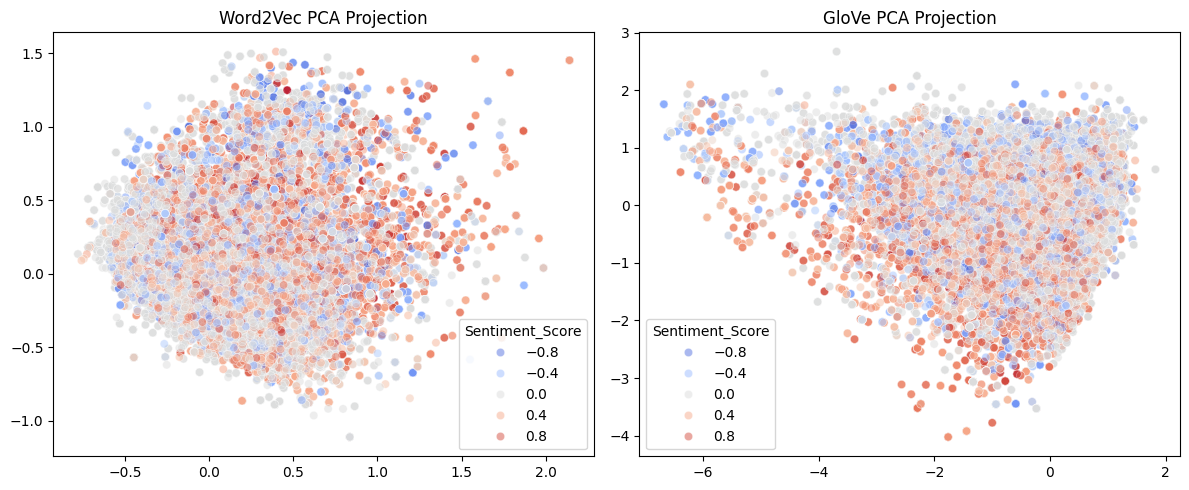

In [ ]:
# Load the datasets
word2vec_file = "merged_dataset_with_Word2Vec_Sentiment.csv"
glove_file = "merged_dataset_with_Glove_Sentiment.csv"

df_word2vec = pd.read_csv(word2vec_file)
df_glove = pd.read_csv(glove_file)

# Convert embeddings from string to numpy arrays
def parse_embedding(embedding_str):
    return np.array([float(x) for x in embedding_str.strip("[]").split(", ")])

df_word2vec["Embeddings"] = df_word2vec["Word2Vec_Embeddings"].apply(parse_embedding)
df_glove["Embeddings"] = df_glove["GloVe_Embeddings"].apply(parse_embedding)

# Compute average variance per dimension
word2vec_var = np.var(np.vstack(df_word2vec["Embeddings"]), axis=0).mean()
glove_var = np.var(np.vstack(df_glove["Embeddings"]), axis=0).mean()

# Compute correlation with Sentiment Score
word2vec_corr, _ = spearmanr(df_word2vec["Sentiment_Score"], np.linalg.norm(np.vstack(df_word2vec["Embeddings"]), axis=1))
glove_corr, _ = spearmanr(df_glove["Sentiment_Score"], np.linalg.norm(np.vstack(df_glove["Embeddings"]), axis=1))

# Print results
print(f"**Embedding Variance**")
print(f"Word2Vec Avg Variance: {word2vec_var:.6f}")
print(f"GloVe Avg Variance: {glove_var:.6f}\n")

print(f"**Correlation with Sentiment Scores**")
print(f"Word2Vec Correlation: {word2vec_corr:.4f}")
print(f"GloVe Correlation: {glove_corr:.4f}")

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# PCA Scatter Plot
pca = PCA(n_components=2)
word2vec_pca = pca.fit_transform(np.vstack(df_word2vec["Embeddings"]))
glove_pca = pca.fit_transform(np.vstack(df_glove["Embeddings"]))

sns.scatterplot(x=word2vec_pca[:, 0], y=word2vec_pca[:, 1], hue=df_word2vec["Sentiment_Score"], palette="coolwarm", ax=ax[0], alpha=0.5)
ax[0].set_title("Word2Vec PCA Projection")

sns.scatterplot(x=glove_pca[:, 0], y=glove_pca[:, 1], hue=df_glove["Sentiment_Score"], palette="coolwarm", ax=ax[1], alpha=0.5)
ax[1].set_title("GloVe PCA Projection")

plt.tight_layout()
plt.show()

## Observations on Word2Vec vs GloVe for Emotion Classification

### Why we chose GloVe:
- **Broader Semantic Understanding**: 
  Emotion classification requires understanding emotions in the context of a broader dataset, GloVe offer an advantage due to its ability to capture global word co-occurrences. This could help the model generalize better across different sentence structures and contexts.

- **Robustness Across Larger Datasets**: 
  Since GloVe embeddings tend to be more generalized, they may offer better performance when working with larger datasets. This is because they take into account the overall co-occurrence patterns in the corpus rather than just the local context of each word.

------------------------------------------------------------------

## Train Custom Own Embedding

**CBOW**

In [ ]:
# Function to clean and tokenize sentences
def preprocess_text(text):
    if isinstance(text, str):
        tokens = re.findall(r'\b\w+\b', text.lower())
        return tokens if tokens else ["<unk>"]
    return ["<unk>"]

# Load dataset
file_path = "merged_dataset_with_Sentiment.csv"
df = pd.read_csv(file_path)

# Ensure 'sentence' column exists
if "sentence" not in df.columns:
    raise ValueError("🚨 Column 'sentence' not found in the dataset!")

# Tokenize sentences
print("Tokenizing sentences...")
df["tokenized"] = df["sentence"].apply(preprocess_text)

# Train CBOW model
print("Training CBOW Model...")
cbow_model = Word2Vec(
    sentences=df["tokenized"].tolist(),
    vector_size=300,
    window=5,
    sg=0,
    workers=4,
    epochs=10,
    min_count=1
)

# Save model
cbow_model.save("CBOW_model.bin")
print("CBOW Model Saved!")

# Function to compute sentence embeddings
def get_sentence_embedding(words, model):
    valid_vectors = [model.wv[word] for word in words if word in model.wv]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0).tolist()
    return [0] * 300

# Compute embeddings
print("Extracting Sentence Embeddings...")
df["CBOW_Embeddings"] = df["tokenized"].apply(lambda x: get_sentence_embedding(x, cbow_model))

# Save embeddings as CSV
output_file = "merged_dataset_CBow_Sentiment.csv"
df.to_csv(output_file, index=False)
print(f"Sentence Embeddings Saved to {output_file} (CSV Format)")

Tokenizing sentences...
Training CBOW Model...
CBOW Model Saved!
Extracting Sentence Embeddings...
entence Embeddings Saved to merged_dataset_CBow_Sentiment.csv (CSV Format)


Loading CBOW Model...
CBOW Model Loaded!
Loading Sentence Embeddings from CSV...
Zero Vectors (Sentences with No Recognized Words): 0 (0.00%)
Plotting PCA Visualization of Embeddings...


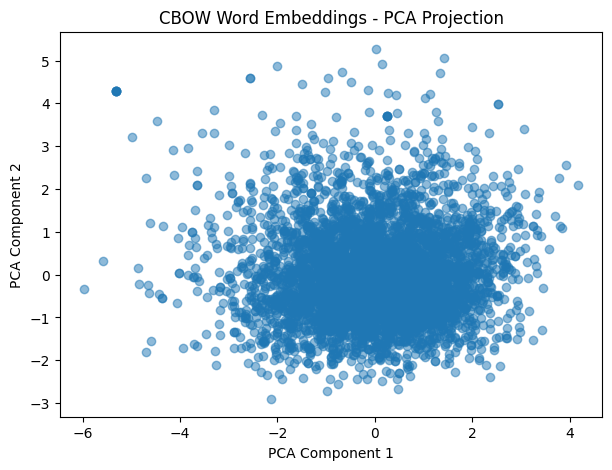

In [3]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import ast  # Import the ast module
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load trained CBOW model
print("Loading CBOW Model...")
cbow_model = Word2Vec.load("CBOW_model.bin")
print("CBOW Model Loaded!")

# Load dataset
print("Loading Sentence Embeddings from CSV...")
df = pd.read_csv("merged_dataset_CBow_Sentiment.csv")

# Convert embedding column from string to list of floats
df["CBOW_Embeddings"] = df["CBOW_Embeddings"].apply(lambda x: np.array(ast.literal_eval(x)))

# Benchmarking: Count zero vectors
zero_vectors = sum(df["CBOW_Embeddings"].apply(lambda x: np.all(x == 0)))
print(f"Zero Vectors (Sentences with No Recognized Words): {zero_vectors} ({zero_vectors / len(df) * 100:.2f}%)")

# PCA Visualization
print("Plotting PCA Visualization of Embeddings...")
pca = PCA(n_components=2)

# Handle large dataset memory issue
sample_size = min(len(df), 5000)
sampled_embeddings = np.vstack(df["CBOW_Embeddings"].sample(sample_size, random_state=42).values)
pca_result = pca.fit_transform(sampled_embeddings)

# Plot PCA
plt.figure(figsize=(7, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("CBOW Word Embeddings - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
# Load dataset with embeddings
file_path = "merged_dataset_CBow_Sentiment.csv"
df = pd.read_csv(file_path)

# Convert embedding column from string to numpy array
df["CBOW_Embeddings"] = df["CBOW_Embeddings"].apply(lambda x: np.array(ast.literal_eval(x)))

# Compute variance across all embedding dimensions
embedding_variance = np.var(np.vstack(df["CBOW_Embeddings"].values), axis=0)

# Display average variance across dimensions
print(f"Average Variance Across Embedding Dimensions: {embedding_variance.mean():.6f}")

Average Variance Across Embedding Dimensions: 0.086652


In [ ]:
# Ensure sentiment score column exists
if "Sentiment_Score" not in df.columns:
    raise ValueError("Sentiment score column not found in the dataset!")

# Compute sentence-level embedding averages
df["Embedding_Mean"] = df["CBOW_Embeddings"].apply(lambda x: np.mean(x))

# Compute Pearson correlation
correlation, p_value = pearsonr(df["Embedding_Mean"], df["Sentiment_Score"])

print(f"Pearson Correlation Between Embeddings & Sentiment Scores: {correlation:.6f} (p-value: {p_value:.6f})")

Pearson Correlation Between Embeddings & Sentiment Scores: 0.063193 (p-value: 0.000000)


-------------------------

### SkipGram

In [ ]:
# Function to clean and tokenize sentences
def preprocess_text(text):
    if isinstance(text, str):
        tokens = re.findall(r'\b\w+\b', text.lower())
        return tokens if tokens else ["<unk>"]
    return ["<unk>"]

# Load dataset
file_path = "merged_dataset_with_Sentiment.csv"
df = pd.read_csv(file_path)

# Ensure 'sentence' column exists
if "sentence" not in df.columns:
    raise ValueError("Column 'sentence' not found in the dataset!")

# Tokenize sentences
print("Tokenizing sentences...")
df["tokenized"] = df["sentence"].apply(preprocess_text)

# Train Skip-Gram model
print("Training Skip-Gram Model...")
skipgram_model = Word2Vec(
    sentences=df["tokenized"].tolist(),
    vector_size=300,
    window=5,
    sg=1,
    workers=4,
    epochs=10,
    min_count=2
)

# Save model
skipgram_model.save("SkipGram_model.bin")
print("Skip-Gram Model Saved!")

# Function to compute sentence embeddings
def get_sentence_embedding(words, model):
    valid_vectors = [model.wv[word] for word in words if word in model.wv]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0).tolist()
    return [0] * 300

# Compute embeddings
print("Extracting Sentence Embeddings...")
df["SkipGram_Embeddings"] = df["tokenized"].apply(lambda x: get_sentence_embedding(x, skipgram_model))

# Save embeddings as CSV
output_file = "merged_dataset_SkipGram_Sentiment.csv"
df.to_csv(output_file, index=False)
print(f"Sentence Embeddings Saved to {output_file}")

Tokenizing sentences...
Training Skip-Gram Model...
Skip-Gram Model Saved!
Extracting Sentence Embeddings...
Sentence Embeddings Saved to merged_dataset_SkipGram_Sentiment.csv (CSV Format)


Loading Skip-Gram Model...
Skip-Gram Model Loaded!
Loading Sentence Embeddings from CSV...
Zero Vectors (Sentences with No Recognized Words): 6 (0.00%)
Plotting PCA Visualization of Embeddings...


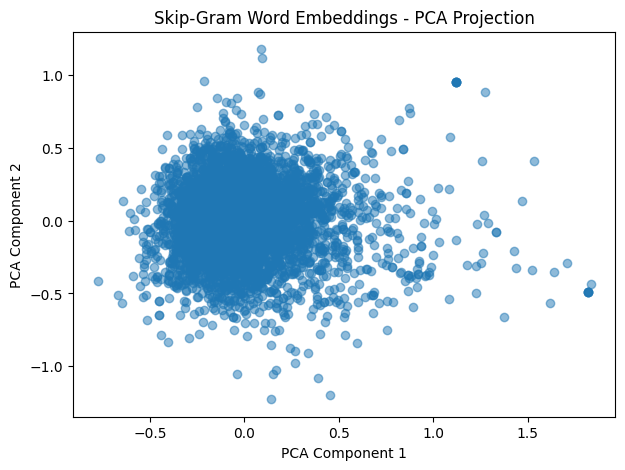

In [ ]:
# Load trained Skip-Gram model
print("Loading Skip-Gram Model...")
skipgram_model = Word2Vec.load("SkipGram_model.bin")
print("Skip-Gram Model Loaded!")

# Load dataset
print("Loading Sentence Embeddings from CSV...")
df = pd.read_csv("merged_dataset_SkipGram_Sentiment.csv")

# Convert embedding column from string to list of floats
df["SkipGram_Embeddings"] = df["SkipGram_Embeddings"].apply(lambda x: np.array(ast.literal_eval(x)))

# Benchmarking: Count zero vectors
zero_vectors = sum(df["SkipGram_Embeddings"].apply(lambda x: np.all(x == 0)))
print(f"Zero Vectors (Sentences with No Recognized Words): {zero_vectors} ({zero_vectors / len(df) * 100:.2f}%)")

# PCA Visualization
print("Plotting PCA Visualization of Embeddings...")
pca = PCA(n_components=2)

# Handle large dataset memory issue
sample_size = min(len(df), 5000)
sampled_embeddings = np.vstack(df["SkipGram_Embeddings"].sample(sample_size, random_state=42).values)
pca_result = pca.fit_transform(sampled_embeddings)

# Plot PCA
plt.figure(figsize=(7, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("Skip-Gram Word Embeddings - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
# Load dataset with embeddings
file_path = "merged_dataset_SkipGram_Sentiment.csv"  # Change to SkipGram if needed
df = pd.read_csv(file_path)

# Convert embedding column from string to numpy array
import ast  # To safely convert string representation of lists
df["SkipGram_Embeddings"] = df["SkipGram_Embeddings"].apply(lambda x: np.array(ast.literal_eval(x)))

# Compute variance across all embedding dimensions
embedding_variance = np.var(np.vstack(df["SkipGram_Embeddings"].values), axis=0)

# Display average variance across dimensions
print(f"Average Variance Across Embedding Dimensions: {embedding_variance.mean():.6f}")

Average Variance Across Embedding Dimensions: 0.008999


In [ ]:
# Ensure sentiment score column exists
if "Sentiment_Score" not in df.columns:
    raise ValueError("Sentiment score column not found in the dataset!")

# Compute sentence-level embedding averages
df["Embedding_Mean"] = df["SkipGram_Embeddings"].apply(lambda x: np.mean(x))

# Compute Pearson correlation
correlation, p_value = pearsonr(df["Embedding_Mean"], df["Sentiment_Score"])

print(f"Pearson Correlation Between Embeddings & Sentiment Scores: {correlation:.6f} (p-value: {p_value:.6f})")

Pearson Correlation Between Embeddings & Sentiment Scores: 0.045643 (p-value: 0.000000)


Conclusion: CBOW embeddings capture slightly more sentiment information than Skip-Gram embeddings, but the correlation is still weak. This suggests that word embeddings alone may not be sufficient for sentiment prediction, and other features (such as TF-IDF, sentiment lexicons, or transformer embeddings) might help

-----------------------------

## NER(Name Entity Recognition) Extraction

In [ ]:
# Initialize tqdm for pandas
tqdm.pandas()

# Load the large spaCy model
nlp = spacy.load("en_core_web_lg")

# Load the dataset
file_path = "CARER_processed_v2.csv"
df = pd.read_csv(file_path)

# Define function to extract named entities
def extract_named_entities(text):
    if not isinstance(text, str):
        return {}, {}  # Return empty dictionaries

    doc = nlp(text)
    
    entity_dict = {
        "PERSON": [],
        "ORG": [],
        "GPE": [],
        "LOC": [],
        "NORP": [],
    }
    
    for ent in doc.ents:
        if ent.label_ in entity_dict:
            entity_dict[ent.label_].append(ent.text)

    # Convert entity lists to strings for easier storage
    entity_strs = {key: ", ".join(set(values)) for key, values in entity_dict.items()}
    entity_counts = {f"Num_{key}": len(values) for key, values in entity_dict.items()}
    
    return entity_strs, entity_counts  # Make sure both are dicts

# Apply NER extraction to each sentence with progress bar
print("Extracting Named Entities...")
ner_results = df["sentence"].progress_apply(extract_named_entities)

# Extract separate dictionaries for entity names & counts
df_entities = pd.DataFrame([x[0] for x in ner_results if isinstance(x[0], dict)])
df_counts = pd.DataFrame([x[1] for x in ner_results if isinstance(x[1], dict)])

# Merge entity data into the main dataframe
df = pd.concat([df, df_entities, df_counts], axis=1)

# Create binary flags for entity presence & convert to 0/1
for entity in df_entities.columns:
    df[f"Has_{entity}"] = (df[f"Num_{entity}"] > 0).astype(int)  # Convert True/False to 0/1

# Save the updated dataset with NER features
output_file = "CARER_processed_v2_afterNER.csv"
df.to_csv(output_file, index=False)
print(f"NER Extraction Complete! Saved to {output_file}")


c:\Users\USER\anaconda3\envs\whisper_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting Named Entities...


100%|██████████| 381626/381626 [24:32<00:00, 259.18it/s]


NER Extraction Complete! Saved to CARER_processed_v2_afterNER.csv


In [ ]:
# Load the dataset
file_path = "merged_dataset_NER.csv"
df = pd.read_csv(file_path)

# Extract all entity columns dynamically
entity_types = ["PERSON", "ORG", "GPE", "LOC", "NORP"]
count_columns = [f"Num_{col}" for col in entity_types]
has_columns = [f"Has_{col}" for col in entity_types]

# Check if all expected columns are present
missing_columns = [col for col in entity_types + count_columns + has_columns if col not in df.columns]
if missing_columns:
    print(f"Missing NER columns: {missing_columns}")
else:
    print("All expected NER columns are present!")

# Summarize entity counts
print("\n**NER Entity Counts (Total occurrences per type):**")
for col in entity_types:
    total_mentions = df[f"Num_{col}"].sum()
    num_sentences = df[f"Has_{col}"].sum()
    print(f"{col}: {total_mentions} total mentions across {num_sentences} sentences")

# Sample sentences with entities
print("\n**Sample Rows with Extracted Entities:**")
df_with_entities = df[df[has_columns].any(axis=1)]
print(df_with_entities[["sentence"] + entity_types].sample(10, random_state=42))

# Show some rows where no entities were found (for comparison)
print("\n**Sample Rows Without Entities:**")
df_without_entities = df[~df[has_columns].any(axis=1)]
print(df_without_entities[["sentence"]].sample(10, random_state=42))


All expected NER columns are present!

**NER Entity Counts (Total occurrences per type):**
PERSON: 39572.0 total mentions across 32731 sentences
ORG: 19805.0 total mentions across 18026 sentences
GPE: 11500.0 total mentions across 10031 sentences
LOC: 1075.0 total mentions across 1038 sentences
NORP: 3245.0 total mentions across 3043 sentences

**Sample Rows with Extracted Entities:**
                                                 sentence  PERSON       ORG  \
4454                              Does that include Drew?    Drew       NaN   
98127   Good. The US is behaving shamefully, the least...     NaN       NaN   
157208  Most countries function as a faux democracy I ...     NaN  Congress   
145067                           Noémie can hug them too.  Noémie       NaN   
58934   That's a bold move, Liang. Let's see if it pay...   Liang       NaN   
86749   Harry's appears to actually be worse. Check ou...   Harry       NaN   
187979  put that mofo in a wheelchair next sseason, ge...  

In [ ]:
# Load the NER dataset
file_path = "merged_dataset_NER.csv"
df = pd.read_csv(file_path)

# Display column names to confirm entity structure
print("Column Names:", df.columns.tolist())

# Display some sample rows where entities were extracted
print("\n**Sample Rows with Extracted Entities:**")
df_with_entities = df[df.filter(like="Num_").sum(axis=1) > 0]  # Rows where at least one entity is present
print(df_with_entities.sample(10, random_state=42))

# Count how many rows have NO entities at all
no_entity_rows = df[df.filter(like="Num_").sum(axis=1) == 0]
print(f"\nSentences with NO Named Entities: {len(no_entity_rows)} ({(len(no_entity_rows)/len(df)) * 100:.2f}%)")

# Display distribution of entity types
entity_columns = [col for col in df.columns if col.startswith("Num_")]
entity_distribution = df[entity_columns].sum()

print("\n**Distribution of Extracted Named Entities:**")
print(entity_distribution)

# Show a few rows where entity extraction failed (for debugging)
print("\n**Rows Without Extracted Entities (Random Sample):**")
print(no_entity_rows.sample(10, random_state=42))

Column Names: ['sentence', 'emotion', 'dataset_source', 'PERSON', 'ORG', 'GPE', 'LOC', 'NORP', 'Num_PERSON', 'Num_ORG', 'Num_GPE', 'Num_LOC', 'Num_NORP', 'Has_PERSON', 'Has_ORG', 'Has_GPE', 'Has_LOC', 'Has_NORP']

**Sample Rows with Extracted Entities:**
                                                 sentence  emotion  \
4454                              Does that include Drew?  neutral   
98127   Good. The US is behaving shamefully, the least...    anger   
157208  Most countries function as a faux democracy I ...  neutral   
145067                           Noémie can hug them too.  neutral   
58934   That's a bold move, Liang. Let's see if it pay...  neutral   
86749   Harry's appears to actually be worse. Check ou...  neutral   
187979  put that mofo in a wheelchair next sseason, ge...  neutral   
60044   I'll probably do the same thing next year that...  neutral   
63204   We need Etenia to take a 7 year deal or less. ...  neutral   
164784  Eagles lucked out between the missed 

## Merge all datasets together(No Dupes)

In [ ]:
# Define file paths
base_file = "merged_dataset_with_Sentiment.csv"  # Base dataset (sentences, emotion labels, sentiment)
pos_file = "merged_dataset_with_POS.csv"
tfidf_ml_file = "merged_dataset_TF-IDF_10k.csv"  # TF-IDF 10K for ML
tfidf_dl_file = "merged_dataset_TF-IDF_50k.csv"  # TF-IDF 50K for DL
glove_file = "merged_dataset_with_Glove_Sentiment.csv"  # GloVe embeddings
ner_file = "merged_dataset_NER.csv"  # Named Entity Recognition

# Load datasets
print("Loading datasets...")
df_base = pd.read_csv(base_file)

# Drop duplicate columns from feature datasets before merging
df_pos = pd.read_csv(pos_file).drop(columns=["emotion", "dataset_source"], errors="ignore")
df_tfidf_ml = pd.read_csv(tfidf_ml_file).drop(columns=["emotion", "dataset_source"], errors="ignore")
df_tfidf_dl = pd.read_csv(tfidf_dl_file).drop(columns=["emotion", "dataset_source"], errors="ignore")
df_glove = pd.read_csv(glove_file).drop(columns=["emotion", "dataset_source", "Sentiment_Score"], errors="ignore")
df_ner = pd.read_csv(ner_file).drop(columns=["emotion", "dataset_source"], errors="ignore")

# Ensure "sentence" column is unique before merging
def check_uniqueness(df, name):
    print(f"Checking uniqueness of '{name}' dataset...")
    if df["sentence"].duplicated().sum() > 0:
        print(f"WARNING: {df['sentence'].duplicated().sum()} duplicate sentences found in {name}! Removing duplicates.")
        df = df.drop_duplicates(subset=["sentence"])
    return df

df_base = check_uniqueness(df_base, "Base")
df_pos = check_uniqueness(df_pos, "POS")
df_tfidf_ml = check_uniqueness(df_tfidf_ml, "TF-IDF ML")
df_tfidf_dl = check_uniqueness(df_tfidf_dl, "TF-IDF DL")
df_glove = check_uniqueness(df_glove, "GloVe")
df_ner = check_uniqueness(df_ner, "NER")

# **Optimize memory usage**
def optimize_memory(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    return df

df_base = optimize_memory(df_base)
df_pos = optimize_memory(df_pos)
df_tfidf_ml = optimize_memory(df_tfidf_ml)
df_tfidf_dl = optimize_memory(df_tfidf_dl)
df_glove = optimize_memory(df_glove)
df_ner = optimize_memory(df_ner)

# **Step-by-step merging to avoid memory issues**
print("Merging datasets in steps...")

# Merge base dataset with POS
df_merged = df_base.merge(df_pos, on="sentence", how="left")

# Merge TF-IDF for ML models
df_merged_ml = df_merged.merge(df_tfidf_ml, on="sentence", how="left")

# Merge TF-IDF for DL models
df_merged_dl = df_merged.merge(df_tfidf_dl, on="sentence", how="left")

# Merge GloVe embeddings
df_merged_ml = df_merged_ml.merge(df_glove, on="sentence", how="left")
df_merged_dl = df_merged_dl.merge(df_glove, on="sentence", how="left")

# Merge Named Entity Recognition (NER)
df_merged_ml = df_merged_ml.merge(df_ner, on="sentence", how="left")
df_merged_dl = df_merged_dl.merge(df_ner, on="sentence", how="left")

# Save the final merged versions
df_merged_ml.to_csv("final_merged_ML.csv", index=False)
df_merged_dl.to_csv("final_merged_DL.csv", index=False)

print("Merging complete! Files saved:")
print("- final_merged_ML.csv (TF-IDF 10K for ML models)")
print("- final_merged_DL.csv (TF-IDF 50K for DL models)")

Loading datasets...
Checking uniqueness of 'Base' dataset...
Checking uniqueness of 'POS' dataset...
Checking uniqueness of 'TF-IDF ML' dataset...
Checking uniqueness of 'TF-IDF DL' dataset...
Checking uniqueness of 'GloVe' dataset...
Checking uniqueness of 'NER' dataset...
Merging datasets in steps...
Merging complete! Files saved:
- final_merged_ML.csv (TF-IDF 10K for ML models)
- final_merged_DL.csv (TF-IDF 50K for DL models)


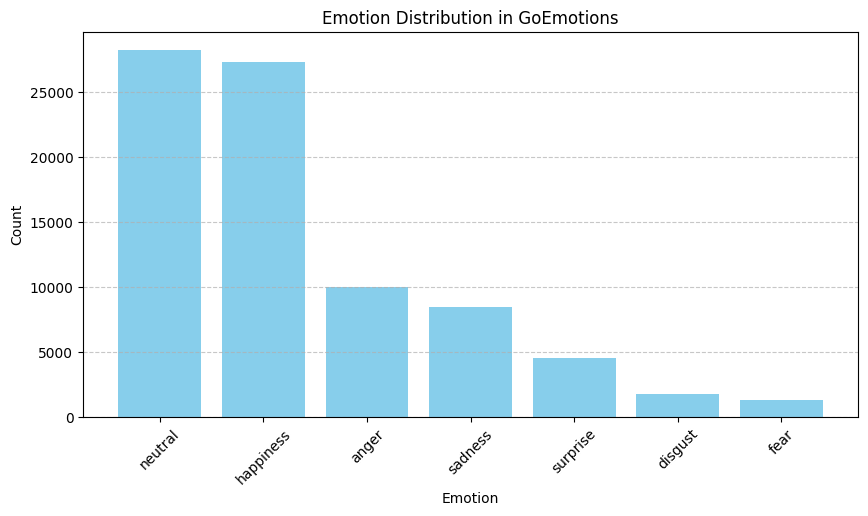

In [ ]:
# Load the merged GoEmotions dataset
file_path = "final_merged_DL.csv"
df = pd.read_csv(file_path)

# Count occurrences of each emotion
emotion_counts = df["emotion"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.index, emotion_counts.values, color="skyblue")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion Distribution in GoEmotions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


----------------------------------

## Add CARER dataset for more data

**EDA AND CLEANING**

In [ ]:
# Define file path
carer_file_path = "merged_training.pkl"

# Load the pickle file into a DataFrame
df_carer = pd.read_pickle(carer_file_path)

# Show the first few rows
print(df_carer.head())

                                                     text emotions
27383   i feel awful about it too because it s my job ...  sadness
110083                              im alone i feel awful  sadness
140764  ive probably mentioned this before but i reall...      joy
100071           i was feeling a little low few days back  sadness
2837    i beleive that i am much more sensitive to oth...     love


In [ ]:
# Save the processed CARER dataset as a CSV file
csv_save_path = "CARER_dataset.csv"
df_carer.to_csv(csv_save_path, index=False)

print(f"CARER dataset saved as {csv_save_path}")

CARER dataset saved as CARER_dataset.csv


In [ ]:
# Load the processed CARER dataset
csv_path = "CARER_dataset.csv"
df_carer = pd.read_csv(csv_path)

# Check for missing values in each column
missing_values = df_carer.isnull().sum()

print("Missing Values in Dataset:")
print(missing_values)

Missing Values in Dataset:
text        0
emotions    0
dtype: int64


In [ ]:
# Count duplicate rows
duplicate_count = df_carer.duplicated().sum()

print(f"Number of Duplicate Entries: {duplicate_count}")

Number of Duplicate Entries: 686


In [ ]:
# Remove duplicate rows
df_carer = df_carer.drop_duplicates()

# Confirm removal
new_duplicate_count = df_carer.duplicated().sum()

print(f"Duplicates removed! Remaining duplicates: {new_duplicate_count}")
print(f"New dataset size: {len(df_carer)}")

Duplicates removed! Remaining duplicates: 0
New dataset size: 416123


In [ ]:
print(df_carer["emotions"].value_counts())

emotions
joy         140779
sadness     120989
anger        57235
fear         47664
love         34497
surprise     14959
Name: count, dtype: int64


In [ ]:
# Define corrected mapping
emotion_mapping = {
    "joy": "happiness",  
    "love": None,
    "sadness": "sadness",
    "anger": "anger",
    "fear": "fear",
    "surprise": "surprise"
}

# Reapply mapping
df_carer["emotions"] = df_carer["emotions"].map(emotion_mapping)

# Drop rows where emotions were mapped to None
df_carer = df_carer.dropna()

# Verify the final emotion distribution
print(df_carer["emotions"].value_counts())
print(df_carer["emotions"].unique())
df_carer.to_csv("CARER_processed_v2.csv", index=False)

emotions
happiness    140779
sadness      120989
anger         57235
fear          47664
surprise      14959
Name: count, dtype: int64
['sadness' 'happiness' 'anger' 'fear' 'surprise']


In [ ]:
# Load the processed CARER dataset
csv_path = "CARER_processed_v2.csv"  # Adjust path if needed
df_carer = pd.read_csv(csv_path)

# Add a new column 'data_source' and fill it with 'CARER'
df_carer["dataset_source"] = "CARER"

# Rename the text column to 'sentence'
df_carer = df_carer.rename(columns={"text": "sentence", "emotions": "emotion"})

# Display the first few rows to verify the new column
print(df_carer.head())
df_carer.to_csv("CARER_processed_v2.csv", index=False)

                                            sentence    emotion dataset_source
0  i feel awful about it too because it s my job ...    sadness          CARER
1                              im alone i feel awful    sadness          CARER
2  ive probably mentioned this before but i reall...  happiness          CARER
3           i was feeling a little low few days back    sadness          CARER
4  i am one of those people who feels like going ...  happiness          CARER


In [ ]:
extract_pos_tags("CARER_processed_v2.csv", "CARER_processed_v2.csv", use_gpu=True)

Processing file: CARER_processed_v2.csv
Running SpaCy with GPU acceleration!


c:\Users\USER\anaconda3\envs\whisper_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 381626/381626 [04:29<00:00, 1417.65it/s]


POS tagging complete! Processed file saved as: CARER_processed_v2.csv


In [ ]:
extract_tfidf("CARER_processed_v2.csv", "CARER_processed_v2.csv", max_features=50000)

Processing file: CARER_processed_v2.csv
Computing TF-IDF...


100%|██████████| 381626/381626 [00:10<00:00, 34841.90it/s]


Successfully saved TF-IDF extracted file: CARER_processed_v2.csv
Saved TF-IDF vectorizer for later use.


In [ ]:
glove_path = "Embeddings\glove.840B.300d\glove.840B.300d.txt"
dataset_path = "CARER_processed_v2.csv"
output_path = "CARER_processed_v2.csv"
    
# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_path)
    
# Process the dataset
result_df = process_dataset(
    dataset_path, 
    glove_embeddings, 
    output_path
)
    
print("Processing complete!")

Loading GloVe embeddings from Embeddings\glove.840B.300d\glove.840B.300d.txt...


0it [00:00, ?it/s]

1003334it [00:47, 21332.42it/s]

Processed 1000000 lines, 999989 vectors loaded...


2003494it [01:34, 21224.37it/s]

Processed 2000000 lines, 1999984 vectors loaded...


2196017it [01:43, 21175.50it/s]


Loaded 2195998 word vectors in 103.72 seconds
Processing dataset: CARER_processed_v2.csv
Dataset loaded with 381626 rows and 5 columns
Generating sentence embeddings...


100%|██████████| 381626/381626 [01:10<00:00, 5416.31it/s]


Saving results to CARER_processed_v2.csv
Processing complete!


**Check for column structure and concatenate**

In [ ]:
# Load the datasets
df1_path = "final_merged_DL.csv"
df2_path = "CARER_processed_v2_afterNER.csv"

df1 = pd.read_csv(df1_path)
df2 = pd.read_csv(df2_path)

# Check if column names match exactly
if list(df1.columns) == list(df2.columns):
    print("Column structure matches!")

    # Concatenate the datasets
    df_combined = pd.concat([df1, df2], ignore_index=True)

    # Verify the row count
    expected_rows = df1.shape[0] + df2.shape[0]
    actual_rows = df_combined.shape[0]

    if actual_rows == expected_rows:
        print(f"Row count matches: {actual_rows} rows")

        # Save the final combined dataset
        output_path = "final_combined_dataset.csv"
        df_combined.to_csv(output_path, index=False)

        print(f"Final dataset saved successfully: {output_path}")
    else:
        print(f"Expected {expected_rows}, but got {actual_rows}. Check for issues.")

else:
    print("Column structures do NOT match")

Column structure matches!
Row count matches: 463230 rows
Final dataset saved successfully: final_combined_dataset.csv
